### It seems that `sbi` always gives conditional posterior $P(\theta|x)$. Try to build our own NDE, not conditioned on anything. Only work on magnitudes.

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from torch import nn, Tensor, optim
import pickle
import matplotlib.pyplot as plt
import numpy as np
import corner

In [6]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [7]:
## Load the NN emulator `speculator`
with open('./best_recon_err_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [8]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

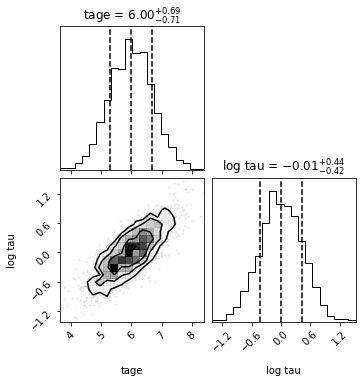

In [9]:
y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=2000)
y_test = Tensor(y_test)
x_test = speculator.predict_sed(y_test)
x_test = Tensor(x_test).to('cuda')

figure = corner.corner(y_test.cpu().detach().numpy(), quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau'],
                       show_titles=True, title_kwargs={"fontsize": 12})

### First, we fit a NDE to `x_test`

In [22]:
from popsed.nde import NeuralDensityEstimator

In [23]:
NDE = NeuralDensityEstimator(method='nsf')
NDE.build(x_test, optimizer='adam')

Training NDE: 100%|██████████████████████████████████████████████████████████████████| 4000/4000 [03:17<00:00, 20.24epochs/s]


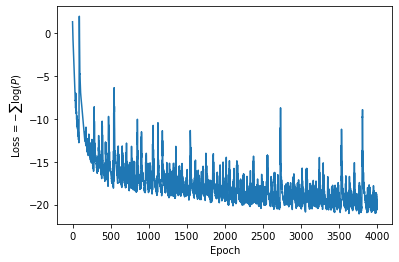

In [24]:
NDE.train(n_epochs=4000, display=True)

In [31]:
with open('./best_loss_model_nde_nsf.pkl', 'rb') as f:
    NDE = pickle.load(f)

In [32]:
samples = NDE.sample(2000)

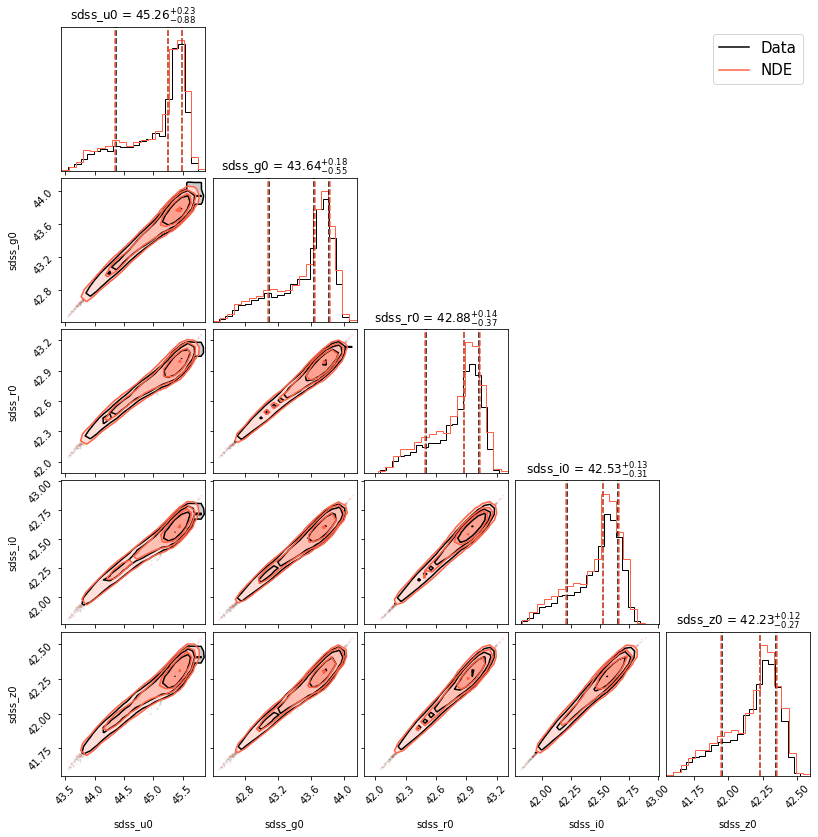

In [37]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
r_line = mlines.Line2D([], [], color='tomato', label='NDE')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels,
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='tomato', quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, r_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

### Second, we try to achieve our goal, with loss = NDE.log_prob(X), where X is the model output.

In [18]:
maf = build_maf(y_test)
optimizer = optim.Adam(maf.parameters())
samples = maf.sample(5000, batch_size=None)
_coeff = speculator.predict(samples)#.cpu().detach().numpy()

In [154]:
num_iter = 5000

for i in range(num_iter):
    optimizer.zero_grad()
    loss = ???????????
    loss.backward()
    optimizer.step()

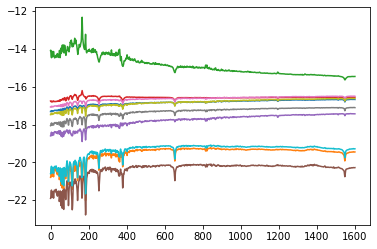

In [17]:
plt.plot(_spec.cpu().detach().numpy().T)

In [63]:
samples = maf.sample(10000,).detach().numpy()

 In order to get the distribution of theta using an ensemble of spectra, the neural density estimator should estimate the posterior conditioned on an ensemble of spectra, not on a single spectrum. But I didn't figure out how to do this using `sbi`.

In [166]:
## Test the NDE for a single spectrum, generally looks good

In [167]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [168]:
ind = 333
x_o = log_spec_all[ind]

In [169]:
samples = posterior.sample((10000,), x=x_o).detach().numpy()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]